In [1]:
import sys
import json
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from omnixai.data.image import Image
from omnixai.explainers.vision.specific.gradcam.pytorch.gradcam import GradCAM
from PIL import Image as PilImage
from torchvision import models, transforms

from src.modules import ResNetRankNet


/opt/conda/envs/viz/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = Path('../../../../data/Streamflow/fpe_stations')
stations = [s.stem for s in data_dir.iterdir() if s.stem not in ['FOXRC', 'GREENR', 'LANESV', 'WESTKILL', 'VLYB']]
station_imgstats = {
    'Sanderson Brook_01171010': {'mean': [0.50165543, 0.49905466, 0.44549626], 'std': [0.29651537, 0.30103442, 0.30297465]},
    'West Brook 0_01171100': {'mean': [0.40856185, 0.41627383, 0.37548802], 'std': [0.28024212, 0.28181233, 0.27585127]},
    'Avery Brook_River Left_01171000': {'mean': [0.49024195, 0.49386903, 0.43806192], 'std': [0.26507561, 0.26838094, 0.27660497]},
    'West Branch Swift River_01174565': {'mean': [0.31966864, 0.34708576, 0.32003862], 'std': [0.24957836, 0.26086306, 0.26829927]},
}

In [10]:
station = stations[3]
print(station)
# station_images = list((data_dir / station / 'FLOW_CFS/imagesets').rglob('*.JPG'))

model_checkpoint_f = Path(f'../../results/vary_annot_frac.kernighan-lin_test/{station}-pairs-train/train_ranking_model_{station}_1/checkpoints/best_model.ckpt')

preds_f = Path(f'../../results/vary_annot_frac.kernighan-lin_test/{station}-pairs-train/inference/inference_ranking_model_1/inference_results_images.csv')
preds = pd.read_csv(preds_f)
preds['ranked_value'] = preds['value'].rank(ascending=True, pct=True)
preds['ranked_score'] = preds['scores'].rank(ascending=True, pct=True)
preds['rank_residual'] = preds['ranked_score'] - preds['ranked_value']
preds['rank_residual_abs'] = preds['rank_residual'].abs()
# sort by rank residual absolute value
preds = preds.sort_values('rank_residual_abs', ascending=False)

station_images = [ data_dir / station / 'FLOW_CFS' / i for i in preds['filename'] ]


Avery Brook_River Left_01171000


1 3 1440 2048


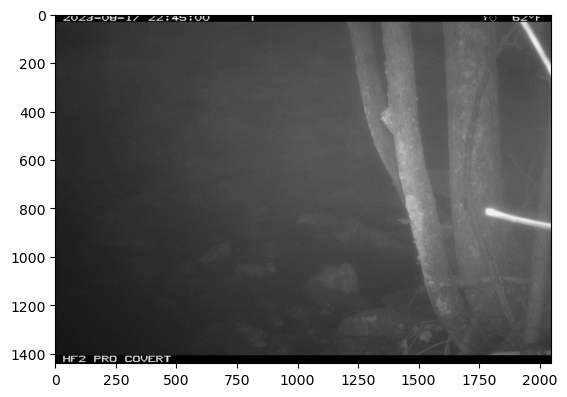

In [11]:
img_path = station_images[1000]
pil_img = PilImage.open(img_path).convert('RGB')
omni_img = Image(pil_img)

img_data = np.array(omni_img.data)
plt.imshow(img_data.squeeze())
# get image shape dimensions
N, H, W, C = img_data.shape
aspect_ratio = W / H
print(N, C, H, W)

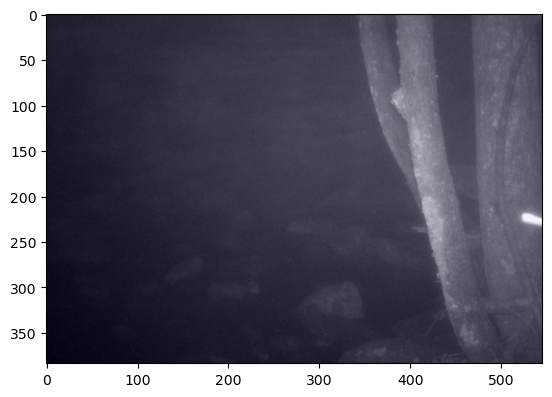

In [12]:
transform = transforms.Compose([
    transforms.Resize((480, np.int32(480 * aspect_ratio))),
    transforms.CenterCrop((384, np.int32(384 * aspect_ratio))),
    transforms.ToTensor(),
    transforms.Normalize(mean=station_imgstats[station]['mean'],
                         std=station_imgstats[station]['std'])
])

img_data_transformed = transform(pil_img)
# Rescale the pixel intensities to the range [0, 1]
img_data_transformed_rescaled = (img_data_transformed - img_data_transformed.min()) / (img_data_transformed.max() - img_data_transformed.min())

# Plot the rescaled image
plt.figure()
plt.imshow(img_data_transformed_rescaled.squeeze().permute(1, 2, 0))
plt.show()


In [13]:
preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims])

In [14]:
model_checkpoint = torch.load(str(model_checkpoint_f))
print(model_checkpoint.keys())
model = ResNetRankNet(
    input_shape=(3, 384, np.int32(384 * aspect_ratio)),
    resnet_size=18,
    truncate=2,
    pretrained=True
)
model = torch.nn.DataParallel(model)
model.load_state_dict(model_checkpoint['model_state_dict'])
model.eval()

# get model out of DataParallel
model = model.module

# replace model.forward with model.forward_single
model.forward = model.forward_single


dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'training_loss'])


/opt/conda/envs/viz/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/viz/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
explainer = GradCAM(
    model=model,
    target_layer=model.resnetbody.model[7][1],
    preprocess_function=preprocess,
    mode="regression"
)
# Explain the top label
explanations = explainer.explain(omni_img)
explanations.ipython_plot(index=0)

/opt/conda/envs/viz/lib/python3.10/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


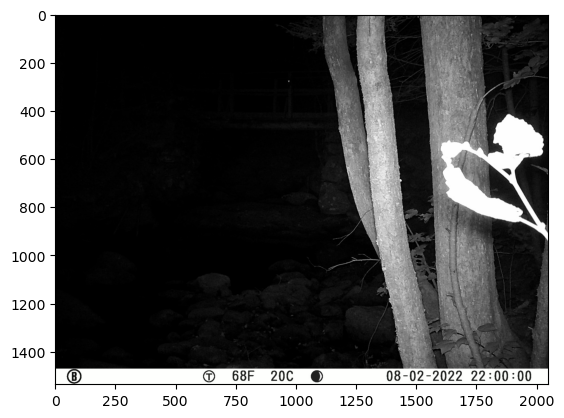

In [26]:
sample_idx = 2501
img2_path = station_images[sample_idx]
pil_img2 = PilImage.open(img2_path).convert('RGB')
# # clip the top 450 pixels
# pil_img2 = pil_img2.crop((0, 450, pil_img2.width, pil_img2.height))
# # clip the left 500 and right 150 pixels
# pil_img2 = pil_img2.crop((500, 0, pil_img2.width - 150, pil_img2.height))
omni_img2 = Image(pil_img2)

img_data2 = np.array(omni_img2.data)
plt.imshow(img_data2.squeeze())
plt.show()

# Explain the top label
explanations = explainer.explain(omni_img2)
explanations.ipython_plot(index=0)

In [18]:
preds.iloc[sample_idx]

Unnamed: 0                                                       50422
station_name                           Avery Brook_River Left_01171000
station_id                                                          15
imageset_id                                                        762
image_id                                                       1581700
timestamp                                    2023-01-07 11:30:00+00:00
filename             imagesets/3bc91424-67d6-46a3-a092-1b4d5c8709e9...
url                  https://usgs-chs-conte-prod-fpe-storage.s3.ama...
interp_value                                                      11.2
max_dtime                                                         15.0
value                                                             11.2
scores                                                        1.312197
ranked_value                                                  0.854487
ranked_score                                                  0.734683
rank_r

In [21]:
len(station_images)

84661

In [249]:
station

'West Branch Swift River_01174565'